In [32]:
from scipy.signal import fftconvolve, convolve2d
from astropy.io import fits
import PIL.Image
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
%matplotlib inline

# settings

In [33]:
simulation = "/home/gijs/Work/spiel/runs/second_kat7_2018-05-28/results/"
neural_output = "/home/gijs/Work/astro-pix2pix/scratch/spiel_test_kat7/fits/"
number = 401

# preface

In [34]:
!ls $simulation

0-settings.txt		   279-skymodel.fits	      458-wsclean-residual.fits
0-skymodel.fits		   279-skymodel.txt	      459-settings.txt
0-skymodel.txt		   279-wsclean-dirty.fits     459-skymodel.fits
0-wsclean-dirty.fits	   279-wsclean-image.fits     459-skymodel.txt
0-wsclean-image.fits	   279-wsclean-model.fits     459-wsclean-dirty.fits
0-wsclean-model.fits	   279-wsclean-psf.fits       459-wsclean-image.fits
0-wsclean-psf.fits	   279-wsclean-residual.fits  459-wsclean-model.fits
0-wsclean-residual.fits    28-settings.txt	      459-wsclean-psf.fits
1-settings.txt		   28-skymodel.fits	      459-wsclean-residual.fits
1-skymodel.fits		   28-skymodel.txt	      46-settings.txt
1-skymodel.txt		   28-wsclean-dirty.fits      46-skymodel.fits
1-wsclean-dirty.fits	   28-wsclean-image.fits      46-skymodel.txt
1-wsclean-image.fits	   28-wsclean-model.fits      46-wsclean-dirty.fits
1-wsclean-model.fits	   28-wsclean-psf.fits	      46-wsclean-image.fits
1-wsclean-psf.fits	   28-wsclean-residual.fits  

In [99]:

psf_path = "{}{}-wsclean-psfbig.fits".format(simulation, number)
outputs_path = "{}{}-outputs.fits".format(neural_output, number)
image_path = "{}{}-wsclean-image.fits".format(simulation, number)
skymodel_path = "{}{}-skymodel.fits".format(simulation, number)
dirty_path = "{}{}-wsclean-dirty.fits".format(simulation, number)
model_path = "{}{}-wsclean-model.fits".format(simulation, number)
convolved_path = "{}{}-convoled.fits".format(simulation, number)
residual_path = "{}{}-residual.fits".format(simulation, number)
residual_path = "/home/gijs/Work/spiel/results/wsclean-residual.fits"

In [100]:
psf = fits.open(psf_path)[0].data.squeeze()
psf = psf / psf.max()
output = fits.open(outputs_path)[0].data.squeeze()    # the output of the neural network
skymodel = fits.open(skymodel_path)[0].data.squeeze() # the skymodel used as input to the telescope sim pipeline
dirty = fits.open(dirty_path)[0].data.squeeze()       # dirty image created by wsclean
image = fits.open(image_path)[0].data.squeeze()       # cleaned image created by wsclean
residual_wsclean = fits.open(residual_path)[0].data.squeeze()       # cleaned image created by wsclean
model_wsclean = fits.open(model_path)[0].data.squeeze()       # cleaned image created by wsclean

In [37]:
threshold = np.mean(output) + np.std(output) * 1
print("threshold: {}".format(threshold))

threshold: 0.012122106418246403


# PSF

In [38]:
psf.shape

(512, 512)

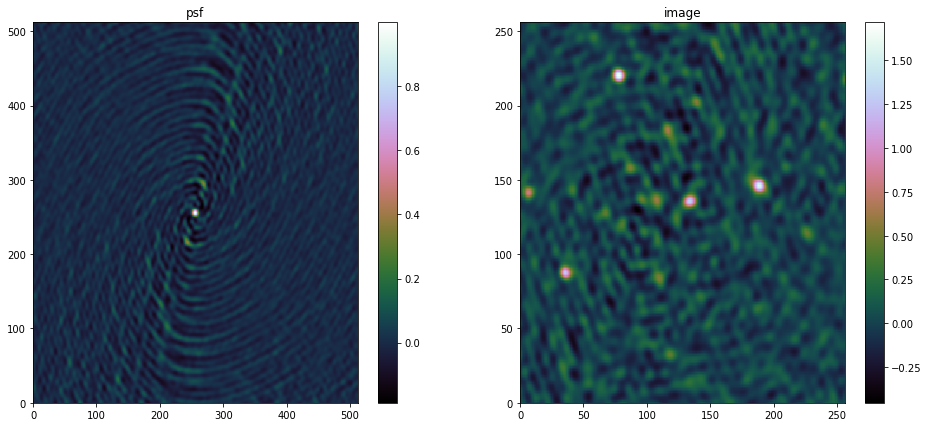

In [76]:
f, (a1, a2) = plt.subplots(1, 2, figsize=(16,7))
i1 = a1.pcolor(psf, cmap='cubehelix')
f.colorbar(i1, ax=a1)
a1.set_title('psf')
i2 = a2.pcolor(image, cmap='cubehelix')
f.colorbar(i2, ax=a2)
_ = a2.set_title('image')

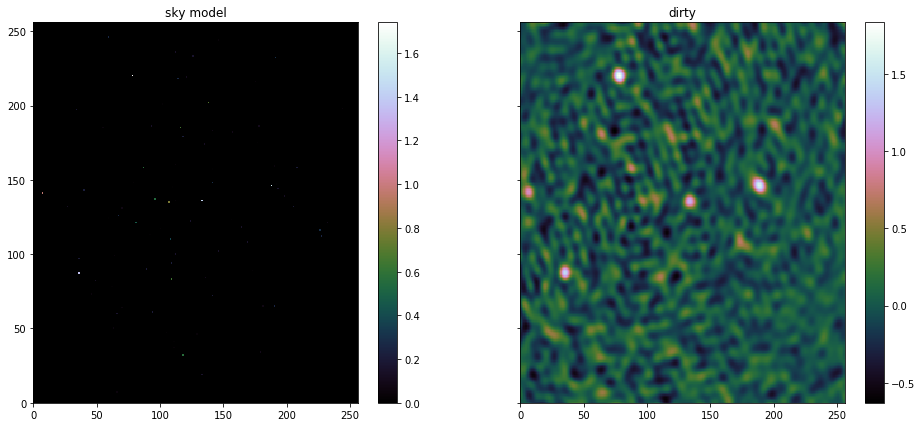

In [40]:
f, (a1, a2) = plt.subplots(1, 2, figsize=(16,7))
i1 = a1.pcolor(skymodel, cmap='cubehelix')
f.colorbar(i1, ax=a1)
a1.set_title('sky model')
i2 = a2.pcolor(dirty, cmap='cubehelix')
f.colorbar(i2, ax=a2)
_ = a2.set_title('dirty')

# thresholding
The scales of the network are still wrong, so we do thresholding and scaling

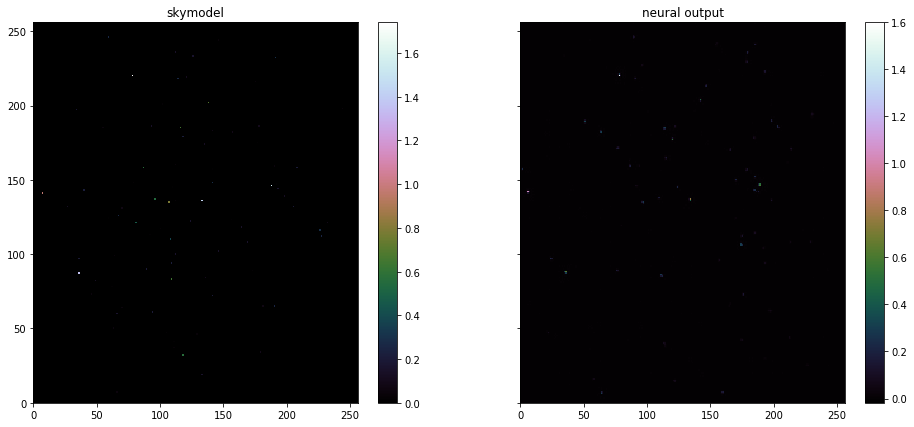

In [41]:
f, (a1, a2) = plt.subplots(1, 2, figsize=(16,7))
i1 = a1.pcolor(skymodel, cmap='cubehelix')
f.colorbar(i1, ax=a1)
a1.set_title('skymodel')
i2 = a2.pcolor(output, cmap='cubehelix')
f.colorbar(i2, ax=a2)
_ = a2.set_title('neural output')

In [60]:
thresholded = output #* (output > threshold)
# disable scaling for now since we can do that with the dirty image
scaled = thresholded # * (skymodel.max()/thresholded.max())

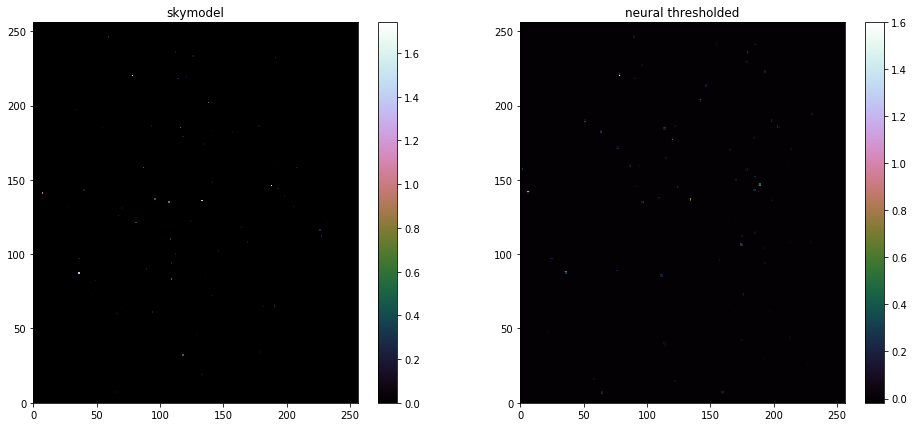

In [77]:
f, (a1, a2) = plt.subplots(1, 2, figsize=(16,7))
i1 = a1.pcolor(skymodel, cmap='cubehelix')
f.colorbar(i1, ax=a1)
a1.set_title('skymodel')
i2 = a2.pcolor(thresholded, cmap='cubehelix')
f.colorbar(i2, ax=a2)
_ = a2.set_title('neural thresholded')

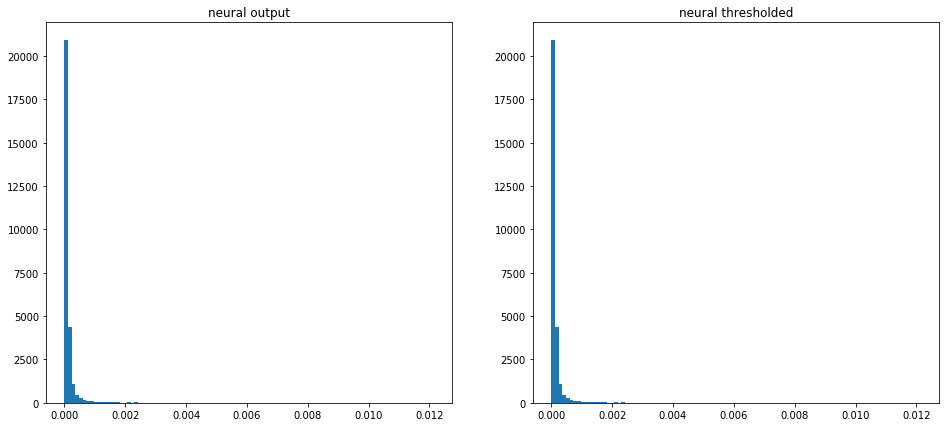

In [79]:
f, (a1, a2) = plt.subplots(1, 2, figsize=(16,7))
a1.hist(output.flatten(), range=(0, threshold), bins=100)
a1.set_title('neural output')
a2.hist(thresholded.flatten(), range=(0, threshold), bins=100)
_ = a2.set_title('neural thresholded')

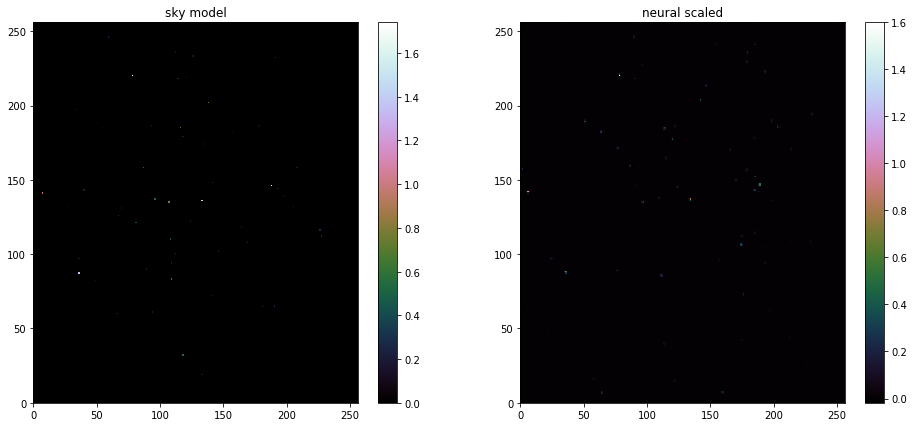

In [80]:
f, (a1, a2) = plt.subplots(1, 2, figsize=(16,7))
i1 = a1.pcolor(skymodel, cmap='cubehelix')
f.colorbar(i1, ax=a1)
a1.set_title('sky model')
i2 = a2.pcolor(scaled, cmap='cubehelix')
f.colorbar(i2, ax=a2)
_ = a2.set_title('neural scaled')

# Convolving

In [64]:
p = psf.shape[0]
r = slice(p//2, -p//2+1)    # uneven PSF needs +2, even psf +1
convolved2 = fftconvolve(skymodel, psf, mode="full")[r,r]

In [102]:
convolved_skymodel = fftconvolve(skymodel, psf, mode="full")[r,r]
convolved_neural = fftconvolve(scaled, psf, mode="full")[r,r]
convolved_model_wsclean = fftconvolve(model_wsclean, psf, mode="full")[r,r]
convolved_skymodel.shape
#convolved_skymodel = fftconvolve(skymodel, psf, mode="same")
#convolved_neural = fftconvolve(scaled, psf, mode="same")

(256, 256)

In [66]:
convolved_neural.shape

(256, 256)

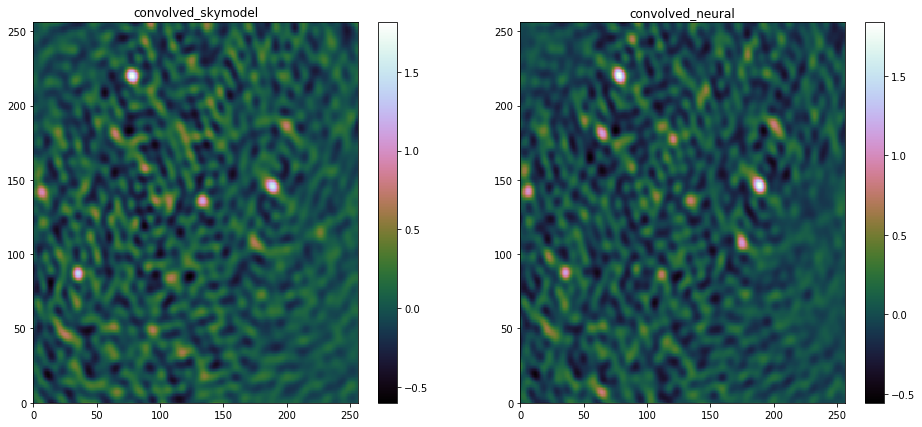

In [81]:
f, (a1, a2) = plt.subplots(1, 2, figsize=(16,7))
i1 = a1.pcolor(convolved_skymodel, cmap='cubehelix')
f.colorbar(i1, ax=a1)
a1.set_title('convolved_skymodel')
i2 = a2.pcolor(convolved_neural, cmap='cubehelix')
f.colorbar(i2, ax=a2)
_ = a2.set_title('convolved_neural')

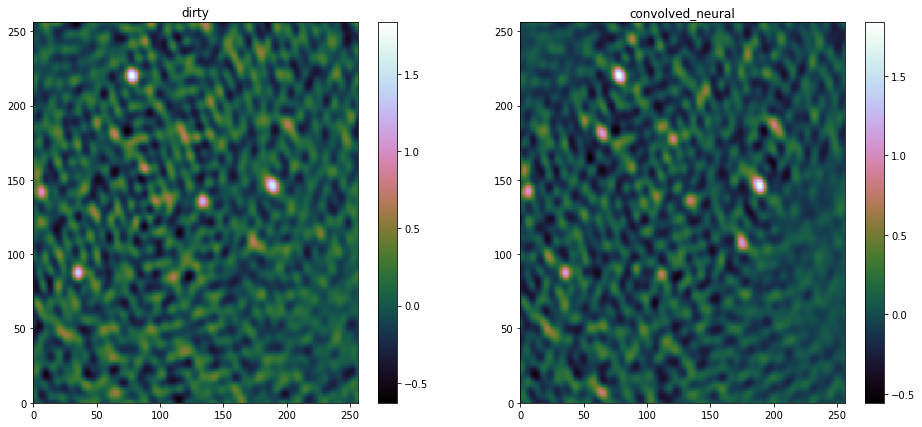

In [82]:
f, (a1, a2) = plt.subplots(1, 2, figsize=(16,7))
i1 = a1.pcolor(dirty, cmap='cubehelix')
f.colorbar(i1, ax=a1)
a1.set_title('dirty')
i2 = a2.pcolor(convolved_neural, cmap='cubehelix')
f.colorbar(i2, ax=a2)
_ = a2.set_title('convolved_neural')

# Risidual

In [69]:
# scale convoled to dirty image
convolved_neural = convolved_neural * (dirty.max() / convolved_neural.max())

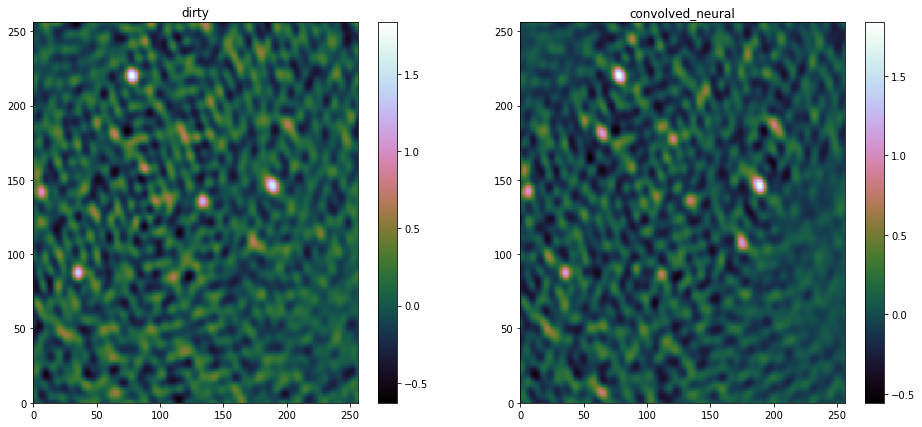

In [83]:
f, (a1, a2) = plt.subplots(1, 2, figsize=(16,7))
i1 = a1.pcolor(dirty, cmap='cubehelix')
f.colorbar(i1, ax=a1)
a1.set_title('dirty')
i2 = a2.pcolor(convolved_neural, cmap='cubehelix')
f.colorbar(i2, ax=a2)
_ = a2.set_title('convolved_neural')

In [103]:
residual_neural = dirty - convolved_neural
residual_skymodel = dirty - convolved_skymodel
residual_model_wsclean = dirty - convolved_model_wsclean

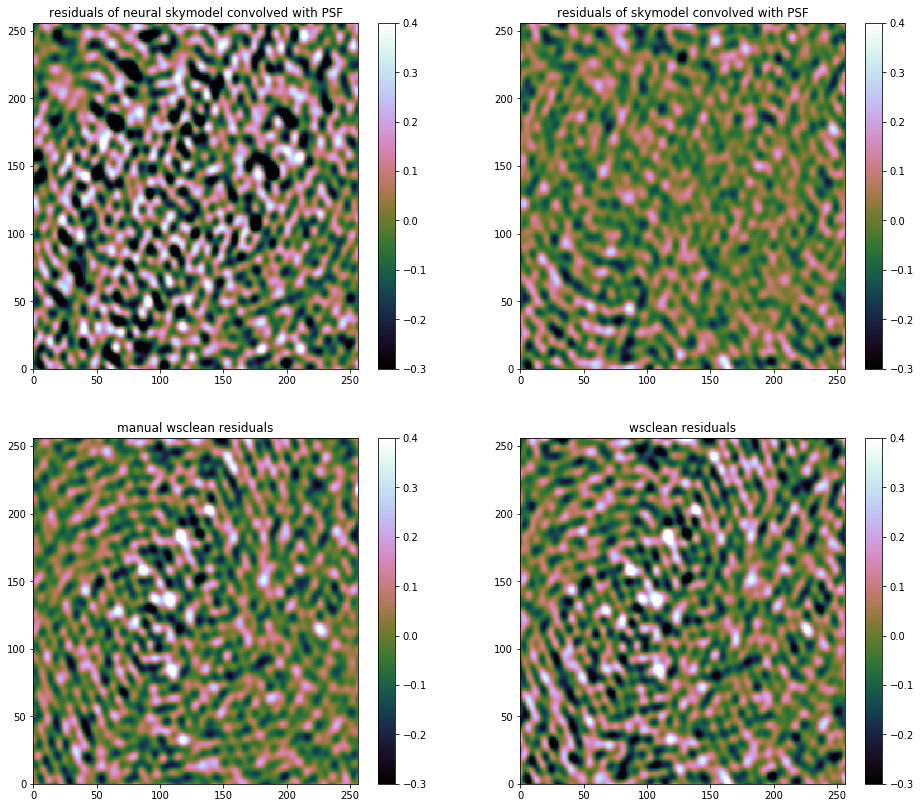

In [104]:
f, ((a1, a2), (a3, a4))= plt.subplots(2, 2, figsize=(16,14))
i1 = a1.pcolor(residual_neural, cmap='cubehelix', vmin=-0.3, vmax=0.4)
a1.set_title('residuals of neural skymodel convolved with PSF')
f.colorbar(i1, ax=a1)
i2 = a2.pcolor(residual_skymodel, cmap='cubehelix', vmin=-0.3, vmax=0.4)
f.colorbar(i2, ax=a2)
a2.set_title('residuals of skymodel convolved with PSF')
i3 = a3.pcolor(residual_wsclean, cmap='cubehelix', vmin=-0.3, vmax=0.4)
a3.set_title('manual wsclean residuals')
f.colorbar(i3, ax=a3)
i4 = a4.pcolor(residual_model_wsclean, cmap='cubehelix', vmin=-0.3, vmax=0.4)
f.colorbar(i4, ax=a4)
_ = a4.set_title('wsclean residuals')

In [98]:
np.std(residual), np.std(residual_neural)

(0.10753989, 0.12364300942653686)

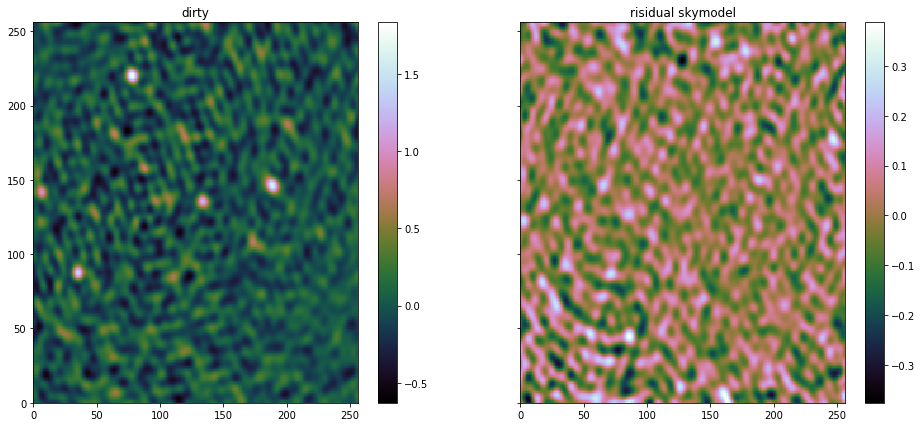

In [73]:
f, (a1, a2) = plt.subplots(1, 2, sharey=True, figsize=(16, 7))
i1 = a1.pcolor(dirty, cmap='cubehelix')
f.colorbar(i1, ax=a1)
a1.set_title('dirty')
i2 = a2.pcolor(risidual_skymodel, cmap='cubehelix')
f.colorbar(i2, ax=a2)
_ = a2.set_title('risidual skymodel')

# write risidual
hdu = fits.PrimaryHDU(risidual_skymodel)
hdu.header = fits.open(dirty_path)[0].header
hdul = fits.HDUList([hdu])
hdul.writeto(risidual_path, overwrite=True)

# write convolved
hdu = fits.PrimaryHDU(convolved_skymodel)
hdu.header = fits.open(dirty_path)[0].header
hdul = fits.HDUList([hdu])
hdul.writeto(convolved_path, overwrite=True)